<a href="https://colab.research.google.com/github/xhaktm3/ssd.pytorch/blob/master/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설정

In [ ]:
# 초기 한번만 실행
# !pip install -U matplotlib

In [ ]:
# package import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.autograd import *
from torchvision import models, transforms

import xml.etree.ElementTree as ET
import cv2
from itertools import product
from math import *

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!echo "현재 작업 디렉토리"
!pwd

Mounted at /content/drive
현재 작업 디렉토리
/content


In [ ]:
# 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트 작성
# 경로 /content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/

def make_datapath_list(rootpath):
    """ 
    데이터 경로를 저장한 리스트 작성

    Parameters
    --------
    rootpath : str
    데이터 폴더 경로

    Returns
    --------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
    데이터 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID(파일이름) 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

# a,b,c,d = make_datapath_list("/content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/")
# print(a[0])

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list("/content/drive/MyDrive/VOC2012/VOCdevkit/VOC2012/")


In [ ]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스

class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환

    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 리스트
    """
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, xml_path, width, height):
        """
        Parameters
        ----------
        xml_path : str
            xml 파일경로
        width : int
            대상 화상 폭
        height : int
            대상 화상 높이

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ...]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼 요소를 가진다.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret = []

        # XML 파일 로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내 물체(object) 수만큼 반복
        for obj in xml.iter('object'):
            
            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            if int(obj.find('difficult').text):
                continue
            
            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in pts:
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0,0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # ret에 더한다
            ret += [bndbox]

        return np.array(ret)
    
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplanet', 'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV사용
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape

# 어노테이션을 리스트로 표시
# print(transform_anno(val_anno_list[ind],width,height))




# 데이터 전처리

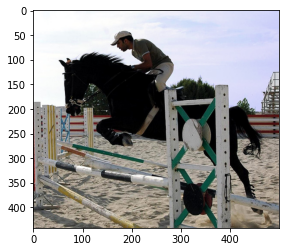

/content/drive/MyDrive/VOC2012/utils/data_augmentation.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


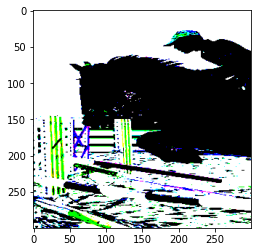

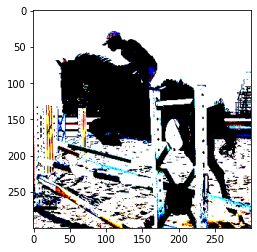

In [ ]:
# utils 폴더에 있는 data_augmentation.py에서 import
# 입력 영상의 전처리 클래스
from drive.MyDrive.VOC2012.utils.data_augmentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상 크기를 300x300으로 한다.
    학습 시 데이터 확장을 수행한다.

    Atrributes
    ----------
    input_size : int
        리사이즈 대상 화상크기
    color_mean : (B, G, R)
        각 색상 채널의 평균값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(), # int를 float32로 변환
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            'val': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' pr 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img,boxes,labels)

# 동작확인

# 1.화상읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104,117,123) #BGR 평균값
input_size = 300
transform = DataTransform(input_size, color_mean)

# 5. Train 화상 표시
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:,:4], anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. Val 화상 표시
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:,:4], anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
# VOC2012의 Dataset 작성

class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상데이터 및 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상 높이, 폭 취득
        '''

        # 1. 화상읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape

        #2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path,width,height)

        #3. 전처리실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:,:4], anno_list[:,4])

        # 색상 채널의 순서 BGR에서 RGB로 변경
        # (높이, 폭, 색상 채널)을 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:,:, (2,1,0)]).permute(2,0,1)

        # BBox와 라벨을 세트로한 np.array를 작성.
        gt= np.hstack((boxes, np.expand_dims(labels,axis=1)))

        return img, gt, height, width

# 동작 확인
color_mean = (104,117,123)
input_size =300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform = DataTransform(
    input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', transform = DataTransform(
    input_size,color_mean),transform_anno=Anno_xml2list(voc_classes))

# 출력 예
# val_dataset[1]

데이터 로더

In [ ]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
    화상 내의 물체 수가 두 개이면 (2,5) 사이즈이지만 세 개이면 (3,5) 등으로 바뀐다.
    변화에 대응하는 Dataloader를 만드는 collate_fn을 작성한다.
    collate_fn은 파이토치 리스트로 mini-batch를 작성하는 함수이다.
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0]) # sample[0]은 화상
        targets.append(torch.FloatTensor(sample[1])) # sample[1]은 어노테이션

    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3,300,300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환
    imgs = torch.stack(imgs,dim=0)
    
    # targets는 어노테이션의 정답인 gt 리스트
    # 리스트 크기는 미니 배치 크기
    # targets 리스트의 요소는 [n,5]
    # n은 화상마다 다르며 화상 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets

In [ ]:
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수 사용
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"]) #반복자로 반환
images, targets = next(batch_iterator) # 첫번째 요소 추출
print(images.size())
print(len(targets))
print(targets[1].size())

print(train_dataset.__len__())
print(val_dataset.__len__())

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])
5717
5823


# SSD 모델

In [ ]:
# 34층의 vgg 모듈

def make_vgg():
    layers = []
    in_channels = 3

    # vgg 모듈 합성곱 층, 최대 풀링 채널 수
    cfg = [64, 64,'M', 128, 128, 'M', 256, 256, 256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과(float)에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # 디폴트는 버리는 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
        
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512,1024,kernel_size=3,padding=6,dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]

    return nn.ModuleList(layers)

#동작확인
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [ ]:
# 8층에 걸친 extras 모듈 작성

def make_extras():
    layers = []
    in_channels = 1024

    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=1)]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=3, stride = 2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=1)]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=3, stride = 2, padding =1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=1)]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=3)]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=1)]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=3)]

    # SSD모듈의 순전파에만 ReLU가 있고 extra는 없다.

    return nn.ModuleList(layers)

#동작확인
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
#디폴트 박스의 오프셋을 출력하는 loc_layers와
#디폴트 박스의 confidence를 출력하는 conf_layers

def make_loc_conf(num_classes = 21, bbox_aspect_num=[4,6,6,6,4,4]):
    loc_layers = []
    conf_layers = []

    # VGG 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512,bbox_aspect_num[0] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(512,bbox_aspect_num[0] * num_classes,kernel_size=3,padding=1)]
    # source2
    loc_layers += [nn.Conv2d(1024,bbox_aspect_num[1] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(1024,bbox_aspect_num[1] * num_classes,kernel_size=3,padding=1)]
    # source3
    loc_layers += [nn.Conv2d(512,bbox_aspect_num[2] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(512,bbox_aspect_num[2] * num_classes,kernel_size=3,padding=1)]
    # source4
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[3] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[3] * num_classes,kernel_size=3,padding=1)]
    # source5
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[4] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[4] * num_classes,kernel_size=3,padding=1)]
    # source6
    loc_layers += [nn.Conv2d(256,bbox_aspect_num[5] * 4,kernel_size=3,padding=1)]
    conf_layers += [nn.Conv2d(256,bbox_aspect_num[5] * num_classes,kernel_size=3,padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

#동작확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
# convC4_3의 출력을 scale=20의 L2Norm으로 정규화하는 층

# 입력 텐서의 사이즈를 확인 후, 웨이트 파라미터를 초기화하여 곱해줌.

class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters() #파라미터초기화
        self.eps =1e-10 # 0으로 나눠지는 것을 방지

    def reset_parameters(self):
        nn.init.constant_(self.weight, self.scale) # 모든 weight 값이 scale이 된다.

    def forward(self,x): # input 사이즈는 torch.Size([batch_num, input_channels, 38, 38])
        # 각 채널의 38x38개 특징량의 채널 방향 제곱합을 계산 후
        # 루트를 구해 나누어 정규화한다
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps
        x = torch.div(x,norm)
        
        # 계수를 곱한다. 계수는 채널마다 하나로 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])인데
        # torch.Size([batch_num,512,38,38])로 변형한다.

        weights = self.weight.unsqeeze(0).unsqeeze(2).unsqeeze(3).expand_as(x)
        out = weights * x

        return out

In [ ]:
# 디폴트 박스를 출력하는 클래스

class DBox(object):
    def __init__(self,cfg):
        super(DBox,self).__init__()

        #초기 설정
        self.image_size=cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg['feature_maps']) # 6
        self.steps = cfg['steps'] # DBox 픽셀 크기
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.aspect_ratios = cfg['aspect_ratios']

    def make_dbox_list(self):
        '''DBox 작성'''
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f),repeat=2):
                f_k = self.image_size / self.steps[k] #특징량의 화상크기 왜 self.steps가 그런값을 갖는지는 알겠지만.. 왜 feature_map을 안쓰는거야?
                cx = (j+0.5)/f_k
                cy = (i+0.5)/f_k

                # 화면비 1 작은 DBox
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx,cy,s_k,s_k]

                # 화면비 1의 큰 DBox
                s_k_prime = sqrt(s_k* (self.max_sizes[k]/self.image_size))
                mean+=[cx,cy,s_k_prime,s_k_prime]

                for ar in self.aspect_ratios[k]:
                    mean+=[cx,cy,s_k*sqrt(ar),s_k/sqrt(ar)]
                    mean+=[cx,cy,s_k/sqrt(ar),s_k*sqrt(ar)]
        output = torch.Tensor(mean).view(-1,4)
        output.clamp_(max=1,min=0)
        return output

# SSD300 설정
ssd_cfg = {
    'num_classes': 21, # 배경 포함 클래스 수
    'input_size': 300, # 화상 입력 크기
    'bbox_aspect_num':[4,6,6,6,4,4], #출력할 Box 화면비 종류
    'feature_maps':[38,19,10,5,3,1], #각 source의 화상 크기
    'steps': [8,16,32,64,100,300], #DBox의 크기를 결정
    'min_sizes':[30,60,111,162,213,264], #DBox의 크기를 결정
    'max_sizes':[60,111,162,213,264,315], #DBox의 크기를 결정
    'aspect_ratios':[[2],[2,3],[2,3],[2,3],[2],[2]],
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

#   test
# pd.DataFrame(dbox_list.numpy())

순전파 생성

In [ ]:
def decode(loc,dbox_list):
    """
    오프셋 정보로 DBOX를 BBOX로 변환한다.
    Parameters
    ----------
    loc: [8732,4]
        SSD모델로 추론하는 오프셋 정보
    dbox_list: [8732,4]
        DBox 정보

    Returns
    -------
    boxes : [xmin,ymin,xmax,ymax]
        BBox 정보
    """

    #Dbox = [cx,cy,width,height]
    #loc = [delta cx, delta cy, delta width, delta height]

    boxes = torch.cat((
        dbox_list[:,:2]+ loc[:,:2]*0.1*dbox_list[:,2:],
        dbox_list[:,2:]*torch.exp(0.2 * loc[:,2:])),dim = 1)
    
    boxes[:,:2] -= boxes[:,2:]/2
    boxes[:,2:] += boxes[:,:2]
    
    return boxes

def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression

    Parameters
    ----------
    boxes : [신뢰도 임곗값(0.01)을 넘은 BBox 수,4]
        bbox정보
    scores:[신뢰도 임곗값(.0.01)을 넘은 BBox 수,]
        conf 정보
    
    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index저장
    count : int
        nms를 통과한 BBox 수
    """

    # return 모형 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()

    # 각 BBox 면적 계산
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = torch.mul(x2-x1,y2-y1)

    # 박스 복사
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    v,idx = scores.sort(0)

    idx = idx[-top_k:]

    while idx.numel()>0:
        i = idx[-1]

        keep[count] = i
        count += 1

        if idx.size(0) == 1:
            break
        
        idx = idx[:-1]

        torch.index_select(x1,0,idx,out=tmp_x1)
        torch.index_select(y1,0,idx,out=tmp_y1)
        torch.index_select(x2,0,idx,out=tmp_x2)
        torch.index_select(y2,0,idx,out=tmp_y2)

        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, min=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, min=y2[i])

        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        tmp_w = torch.clamp(tmp_w, min = 0.0)
        tmp_h = torch.clamp(tmp_h, min = 0.0)

        inter = tmp_w*tmp_h

        rem_areas = torch.index_select(area,0,idx)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union

        idx = idx[IoU.le(overlap)]

    return keep, count 


In [ ]:
class Detect(Function):
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax =nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh
    
    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산

        Parameters
        __________
        loc_data: [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num,8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox 정보

        Returns
        ------
        output : torch.Size([batch_num, 21, 200, 5])
        """

        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)

        conf_data = self.softmax(conf_data)

        output = torch.zeros(num_batch,num_classes,self.top_k,5)

        # confdata [batch_num, num_classes, 8732]
        conf_preds = conf_data.transpose(2,1)

        for i in range(num_batch):
            decoded_boxes = decode(loc_data[i],dbox_list)

            conf_scores = conf_preds[i].clone()

            for cl in range(1, num_classes):
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                scores = conf_scores[cl][c_mask]

                if scores.nelemnt() == 0:
                    continue
                
                l_mask = c_mask.unsqeeze(1).expand_as(decoded_boxes)

                boxes = decoded_boxes[l_mask].view(-1,4)

                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k
                )

                output[i,cl,:count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                 boxes[ids[:count]]),1)
        
        return output 

In [ ]:
# SSD 클래스 작성

class SSD(nn.Module):
    def __init__(self,phase,cfg):
        super(SSD,self).__init__()
        self.pahse = phase #train or inference
        self.num_classes = cfg["num_classes"] #class =21

        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"],cfg["bbox_aspect_num"]
        )

        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        if phase == "inference":
            self.detect = Detect()

    def forward(self, x):
        sources = list()
        loc = list()
        conf = list()

        for k in range(23):
            x = self.vgg[k](x)

        source1 = self.L2Norm(x)
        sources.append(source1)

        for k in range(23,len(self.vgg)):
            x = self.vgg[k](x)
        
        sources.append(x)

        for k,v in enumerate(self.extras):
            x= nn.relu(v(x), inplace=True)
            if (k%2)==1:
                sources.append(x)

        for (x,l,c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0,2,3,1).contiguous())
            conf.append(c(x).permute(0,2,3,1).ontiguous())

        loc = torch.cat([o.view(o.size(0),-1) for o in loc],1)
        conf = torch.cat([o.view(o.size(0),-1) for o in conf],1)

        loc = loc.view(loc.size(0),-1,4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        output = (loc,conf,self.dbox_list)

        if self.phase == "inference":
            return self.detect(output[0], output[1], output[2])
        else:
            return output

# 손실 함수 구현

In [ ]:
# dbox에 jaccard계수를 계산해 해당 dbox를 positive dbox와 negative dbox로 분류하고 positive dbox에 대해선 정답 bbox정보로 true label bbox offset을 계산한다. 
# negative dbox에 경우 배경 label을 학습하는데 사용되며, hard negative mining으로 가장 학습되지 못한 negative dbox를 적정 갯수(positive의 3배 이하)를 고름.
def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior

In [ ]:
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.negpos_ratio = neg_pos
        self.device = device

    def forward(self, predictions, targets):
        """
        손실함수 계산
        
        Parameters
        ----------
        predictions : SSD net의 훈련 시 출력(tuple)
            (loc=torch.size([num_batch,8732,4]), conf=torch.Size([num_batch,8732,21]),dbox_list=torch.Size([8732,4]))

        targets : [num_batch,num_objs,5]

        Returns
        -------
        loss_l : 텐서
            loc의 손실 값
        loss_c : 텐서
            conf의 손실 값
        """
        loc_data, conf_data, dbox_list = predictions

        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)

        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        for idx in range(num_batch):
            truths = targets[idx][:,:-1].to(self.device)
            labels = targets[idx][:,-1].to(self.device)

            dbox = dbox_list.to(self.device)

            variance = [0.1,0.2]
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)
        
        # 위치 손실
        # Smooth L1 함수로 손실계산. Positive Dbox만 계산
        pos_mask = conf_t_label > 0
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        loc_p = loc_data[pos_idx].view(-1,4)
        loc_t = loc_t[pos_idx].view(-1,4)

        loss_l = nn.smooth_l1_loss(loc_p,loc_t,reduction ='sum')

        # 클래스의 손실 : loss_c
        # 교차 엔트로피 오차 함수로 계산, 배경 DBox를 Hard Negative Mining하여, 1:3 비율로만들것
        batch_conf = conf_data.view(-1,num_classes)

        loss_c = nn.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none'
        )

        # Hard Negative Mining 마스크
        # 물체 발견 Dbox의 손실은 0
        num_pos = pos_mask.long().sum(1,keepdim=True)  # 미니 배치별 물체 클래스의 예측 수
        loss_c = loss_c.view(num_batch, -1)
        loss_c[pos_mask] = 0

        # Hard Negative Mining 실시
        _, loss_idx = loss_c.sort(1, descending = True)
        _, idx_rank = loss_idx.sort(1)

        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)].view(-1,num_classes)
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        loss_c = nn.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        N = num_pos.sum()
        loss_l /= N
        loss_c /= NameError
        return loss_l, loss_c

# 학습 및 검증